### Run Project Guide 





- Create a Project in Bigquery as in database and then create a key of it. 
- [Click this link for step by step procedure to create project](https://cloud.google.com/bigquery/docs/quickstarts/load-data-console). Click on Guide me button.
- After successfully creating the project it will create a JSON file.
- Place the JSON file next to this ipynb file. 
- %pip install --upgrade google-cloud-bigquery (run this command)
- You might or might not have to install %pip install db-dtypes. Once done Restart the Kernel 
- Both of the above 2 installations were done in the python cell.
  

### Problem Statement


Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

<b>Questions</b>
1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?
2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?
3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?
4. Plot the distribution of average ETA by hours. How can this plot be explained?

<b>Data Description</b>
We have two data sets: data_orders and data_offers, both being stored in a CSV format. The data_orders data set contains the following columns:

- order_datetime - time of the order
- origin_longitude - longitude of the order
- origin_latitude - latitude of the order
- m_order_eta - time before order arrival
- order_gk - order number
- order_status_key - status, an enumeration consisting of the following mapping:
- 4 - cancelled by client,
- 9 - cancelled by system, i.e., a reject
- is_driver_assigned_key - whether a driver has been assigned
- cancellation_time_in_seconds - how many seconds passed before cancellation
- The data_offers data set is a simple map with 2 columns:

order_gk - order number, associated with the same column from the orders data set
offer_id - ID of an offer

<b>
Make sure that the solution reflects your entire thought process including the preparation of data - it is more important how the code is structured rather than just the final result or plot.</b>

### Approach

In [1]:
import os
from google.cloud import bigquery

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='failed-orders-insights-f569475b0e3e.json'

In [3]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "github_repos" dataset
dataset_ref = client.dataset("failed_orders", project="failed-orders-insights")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)


# List all the tables in the "hacker_news" dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset (there are four!)
for table in tables:  
    print(table.table_id)



# Construct a reference to the "licenses" table
data_orders_ref = dataset_ref.table("data_orders_table")

# API request - fetch the table
data_orders_table = client.get_table(data_orders_ref)

# Preview the first five lines of the "data_orders_table" table
client.list_rows(data_orders_table, max_results=5).to_dataframe()



data_offers_table
data_orders_table


,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN
1,21:21:23,-0.947011,51.456380,NaN,3000583117054,9,0,NaN
2,07:58:15,-0.955637,51.470372,NaN,3000582791789,9,0,NaN
3,07:53:46,-0.978230,51.454575,NaN,3000582791562,9,0,NaN
4,08:53:01,-1.052298,51.454308,NaN,3000582817606,9,0,NaN


In [4]:
# *****************Query********************************
# Query to select the number of transactions per date, sorted by date
query_with_CTE = """ 
                 SELECT * FROM `failed-orders-insights.failed_orders.data_orders_table` 
                 LIMIT 10;
                 """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_with_CTE, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
transactions_by_date = query_job.to_dataframe()

# Print the first five rows
transactions_by_date.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN
1,21:21:23,-0.947011,51.456380,NaN,3000583117054,9,0,NaN
2,07:58:15,-0.955637,51.470372,NaN,3000582791789,9,0,NaN
3,07:53:46,-0.978230,51.454575,NaN,3000582791562,9,0,NaN
4,08:53:01,-1.052298,51.454308,NaN,3000582817606,9,0,NaN


### Creating a function to execute BigQuery queries from the web using BigQuery Python API  

In [5]:
# to set a limit to cancel if it uses too much memory
ONE_GB = 1000*1000*1000

# This function will execute the Bigquery and return a dataframe
def execute_query(query,limit):


# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set)
    safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=limit)
    query_job = client.query(query, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
    return query_job.to_dataframe()

# CONSTANT VALUES FOR VISUALISATION
FIGSIZE = (8,8)
# font sizes for the x and y axis 
LABEL_SIZE = 14
# font size for the title of the figure
TITLE_SIZE = {'fontsize': 16}


### Question 1 
   1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?
   

<i>We are trying to figure out the distribution of cancellation and rejection

 </i>

In [6]:
query_distribution_of_cancellation_rejection = """   

SELECT 
  count(case when is_driver_assigned_key = 0 then 1 else Null end) as driver_not_assigned_count
 ,count(case when is_driver_assigned_key = 1 then 1 else Null end) as driver_assigned_count
 ,count(case when order_status_key = 9 then 1 else NULL end) as system_rejection_count
 ,count(1) as total_entries
  from `failed-orders-insights.failed_orders.data_orders_table`

"""
df_distribution_of_cancellation_rejection=execute_query(query_distribution_of_cancellation_rejection,ONE_GB)

In [7]:
df_distribution_of_cancellation_rejection

,driver_not_assigned_count,driver_assigned_count,system_rejection_count,total_entries
0,7902,2814,3409,10716


In [8]:
# DROPPING THE TOTAL ENTRIES 
df_distribution_of_cancellation_rejection=df_distribution_of_cancellation_rejection.drop(['total_entries'], axis=1)

In [9]:
import matplotlib.pyplot as plt 
import seaborn as sns 



df_distribution_of_cancellation_rejection=df_distribution_of_cancellation_rejection.rename(columns={
    'driver_not_assigned_count':'Driver Not Assigned',
    'driver_assigned_count':'Driver Assigned',
    'system_rejection_count':'Rejected by Driver'
    
    })



df_distribution_of_cancellation_rejection

,Driver Not Assigned,Driver Assigned,Rejected by Driver
0,7902,2814,3409


In [10]:
# retrieving the list of column and values 
columns_list =list(df_distribution_of_cancellation_rejection.columns)
values_list = list(df_distribution_of_cancellation_rejection.iloc[0])

 <i>Creating a graph to show the results.</i> 

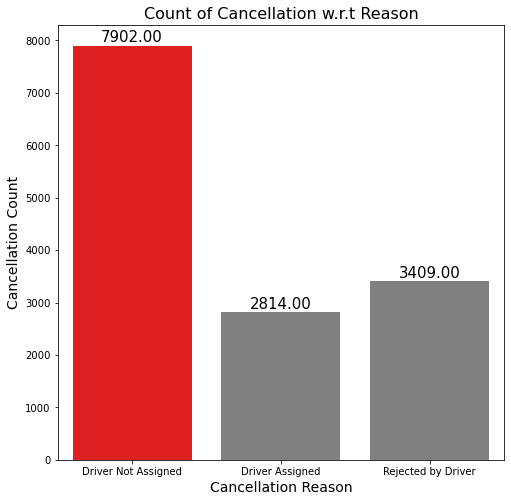

In [11]:


# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked



plt.figure(figsize=FIGSIZE)
clrs = ['grey' if (x < max(values_list)) else 'red' for x in values_list ]
plots = sns.barplot(x=columns_list, y=values_list,palette=clrs)


# Iterrating over the bars one-by-one
for bar in plots.patches:

# Using Matplotlib's annotate function and
# passing the coordinates where the annotation shall be done
# x-coordinate: bar.get_x() + bar.get_width() / 2
# y-coordinate: bar.get_height()
# free space to be left to make graph pleasing: (0, 8)
# ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
    (bar.get_x() + bar.get_width() / 2,
     bar.get_height()), ha='center', va='center',
    size=15, xytext=(0, 8),
    textcoords='offset points')

# Setting the label for x-axis
plt.xlabel("Cancellation Reason", size=LABEL_SIZE)

# Setting the label for y-axis
plt.ylabel("Cancellation Count", size=LABEL_SIZE)

fontsize= 16
# Setting the title for the graph
plt.title("Count of Cancellation w.r.t Reason", fontdict=TITLE_SIZE)

# Finally showing the plot
plt.show()


From the bar plot we can see that,
<li>We can consider that since the driver is not assigned, the customers might get impatient resulting in cancelling the order. <br>
<li>On Comparing the results, we can find that <b>Driver not being assigned</b> to a customer is the most frequent reason for cancelation of orders.
It constituents for <b>74% </b> for the  reason of cancellation. 



<hr>
<i>


One of the  reasons for cancellation by customers is that the drivers are busy with other rides. To understand this lets create a dataframe that consists of the peak hours during which the customers are requesting rides. </i>

In [12]:
query_peak_hours ="""   
--query to find peak time of cancellation 
SELECT 
  EXTRACT(HOUR from order_datetime) as hour
  ,COUNT(EXTRACT(HOUR from order_datetime)) as count_of_cancellation_by_hour 
FROM `failed-orders-insights.failed_orders.data_orders_table`
WHERE order_status_key = 4 
GROUP BY EXTRACT(HOUR from order_datetime)

"""

df_peak_hours = execute_query(query_peak_hours,ONE_GB)

In [13]:
df_peak_hours.sort_values(by='hour',ascending=True)

,hour,count_of_cancellation_by_hour
14,0,418
17,1,307
5,2,315
18,3,288
19,4,91
23,5,40
15,6,114
11,7,320
1,8,727
21,9,304


<i>Lets create a line chart which shows count of orders, by the hour. </i>

In [29]:
median_value_count_cancellation = df_peak_hours['count_of_cancellation_by_hour'].median()
median_value_count_cancellation

import numpy as np

df_peak_hours['more_than_median'] = np.where(df_peak_hours['count_of_cancellation_by_hour']>= median_value_count_cancellation, 1, 0)
df_peak_hours

count_more_than_median = df_peak_hours['more_than_median'].sum()
# pct_more_than_median = (count_more_than_median/df_peak_hours)*100.0

pct_more_than_median = (count_more_than_median/len(df_peak_hours)*100)


print(f"{pct_more_than_median} % of hours in a day have cancellation count higher than the median value {(median_value_count_cancellation)}")


df_peak_hours.sort_values(by="hour",ascending="TRUE")

50.0 % of hours in a day have cancellation count higher than the median value 298.0


,hour,count_of_cancellation_by_hour,more_than_median
14,0,418,1
17,1,307,1
5,2,315,1
18,3,288,0
19,4,91,0
23,5,40,0
15,6,114,0
11,7,320,1
1,8,727,1
21,9,304,1


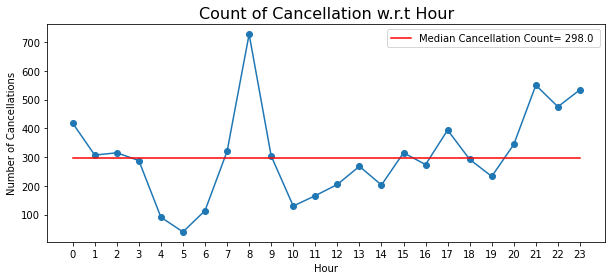

In [15]:
# Plotting a line chart 


plt.figure(figsize=(10,4))
g1=sns.lineplot(x = "hour", y = "count_of_cancellation_by_hour",data=df_peak_hours)
ax1 = sns.lineplot(x = "hour", y = median_value_count_cancellation,data=df_peak_hours,color='r',label = "Median Cancellation Count= 298.0 ")
g1.set_xticks(range(24))
plt.scatter(x = "hour", y = "count_of_cancellation_by_hour", data=df_peak_hours)
plt.xlabel("Hour")
plt.ylabel("Number of Cancellations")

plt.title("Count of Cancellation w.r.t Hour", fontdict=TITLE_SIZE)
plt.show()

We have created a line chart to find the peak hours about when the customers are requesting orders 
<li>The red line signifies the median cancellation count 
<li> We find that there <b>more than 50.0 % of hours in a day have higher cancellation count </b> than the  
    median value 298.0.
<li> There is a <b>high demand during 8am and during midnight</b>
<li>High Cancellation orders during these hours can be rectified by having alloting more drivers during these hours. 

<hr>
<i> Lets try to figure out how much time customers  wait before cancelling their ride</i>

In [16]:
query_avg_waiting_time = """   


-- Query to find out time the customers have to wait before the car arrives 
SELECT EXTRACT(hour from order_datetime) as hour
,AVG(m_order_eta) as avg_waiting_time
FROM `failed-orders-insights.failed_orders.data_orders_table`
WHERE is_driver_assigned_key = 1
group by hour
order by 2 desc




"""
df_avg_waiting_time=execute_query(query_avg_waiting_time,ONE_GB)
df_avg_waiting_time



,hour,avg_waiting_time
0,8,636.910828
1,7,583.358974
2,17,519.742515
3,9,504.891026
4,15,454.790210
5,12,440.787879
6,16,440.568182
7,13,428.025000
8,6,427.148936
9,18,419.186567


In [17]:
median_avg_waiting = df_avg_waiting_time['avg_waiting_time'].median()
median_avg_waiting

import numpy as np

df_avg_waiting_time['more_than_median'] = np.where(df_avg_waiting_time['avg_waiting_time']>= median_avg_waiting, 1, 0)
df_avg_waiting_time

count_more_than_median = df_avg_waiting_time['more_than_median'].sum()
# pct_more_than_median = (count_more_than_median/df_peak_hours)*100.0

pct_more_than_median = (count_more_than_median/len(df_avg_waiting_time)*100)

print(f"{pct_more_than_median} % of hours in a day have  cancellation count higher than the median value {round(median_avg_waiting,2)}")

50.0 % of hours in a day have  cancellation count higher than the median value 399.72


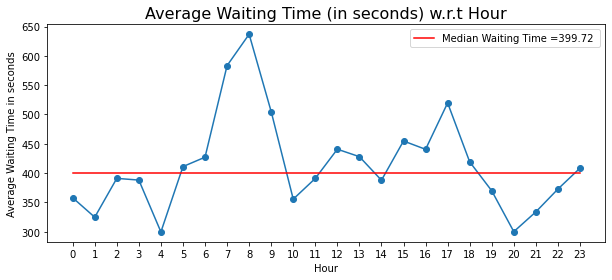

In [18]:
plt.figure(figsize=(10,4))
g1=sns.lineplot(x = "hour", y = "avg_waiting_time",data=df_avg_waiting_time)
ax1 = sns.lineplot(x = "hour", y = median_avg_waiting,data=df_avg_waiting_time,color='r',label = "Median Waiting Time =399.72 ")
g1.set_xticks(range(24))
plt.scatter(x = "hour", y = "avg_waiting_time", data=df_avg_waiting_time)
plt.xlabel("Hour")
plt.ylabel("Average Waiting Time in seconds")

plt.title("Average Waiting Time (in seconds) w.r.t Hour", fontdict=TITLE_SIZE)
plt.show()

In [19]:
# code to convert seconds into minutes and seconds 
df_avg_waiting_time['waiting_minutes'] = df_avg_waiting_time['avg_waiting_time']/60
df_avg_waiting_time['waiting_minutes'] = df_avg_waiting_time['waiting_minutes'].astype(int)


# df_avg_waiting_time=df_avg_waiting_time.drop(['minutes'], axis=1)
df_avg_waiting_time['waiting_seconds'] = df_avg_waiting_time['avg_waiting_time']%60
df_avg_waiting_time['waiting_seconds'] = df_avg_waiting_time['waiting_seconds'].astype(int)
df_avg_waiting_time

,hour,avg_waiting_time,more_than_median,waiting_minutes,waiting_seconds
0,8,636.910828,1,10,36
1,7,583.358974,1,9,43
2,17,519.742515,1,8,39
3,9,504.891026,1,8,24
4,15,454.790210,1,7,34
5,12,440.787879,1,7,20
6,16,440.568182,1,7,20
7,13,428.025000,1,7,8
8,6,427.148936,1,7,7
9,18,419.186567,1,6,59


<li>We can notice that increased waiting time for the ride to come can result in higher cancellation of orders. 
<li> Times between <b>7am-8am and 5pm</b> are periods that have higher waiting i.e <b>8-10 mins</b>. 
<li> The morning time (7am-8am) is <b>52%</b> higher than the median waiting time (5-6mins).
<li> The 8am period is the time frame having the most waiting time as well as the most number of cancellations. 


### Question 2 
Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

<i>Lets create a line chart of rides which are cancelled by customers and drivers.</i>

In [20]:
query_comaprison_waiting_rejection_time = """   

--query to find peak time of cancellation wrt driver and customer  
with cte as (
SELECT 
  EXTRACT(HOUR from order_datetime) as hour
  ,COUNT(CASE WHEN order_status_key=4 then 1 else null end) as client_cancel_count
  ,COUNT(CASE WHEN order_status_key=9 then 1 else null end) as driver_reject_count
  
FROM `failed-orders-insights.failed_orders.data_orders_table`
GROUP BY EXTRACT(HOUR from order_datetime)
)

Select * ,round(((client_cancel_count-driver_reject_count)/driver_reject_count*100.0),2) as pct_change
 from cte 



"""


df_distribution_of_cancellation_rejection= execute_query(query_comaprison_waiting_rejection_time,ONE_GB)
# df_distribution_of_cancellation_rejection.describe()


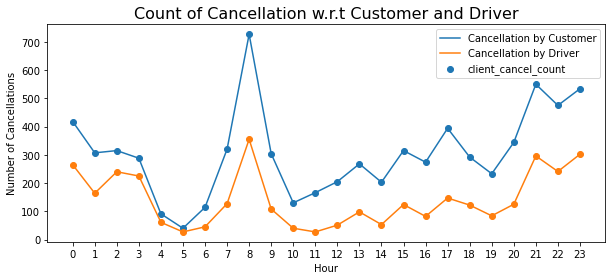

In [21]:
plt.figure(figsize=(10,4))
g1=sns.lineplot(x = "hour", y = "client_cancel_count",data=df_distribution_of_cancellation_rejection,label = "Cancellation by Customer")
plt.scatter(x = "hour", y = "client_cancel_count", data=df_distribution_of_cancellation_rejection)


g1.set_xticks(range(24))
ax1 = sns.lineplot(x = "hour", y = "driver_reject_count",data=df_distribution_of_cancellation_rejection,label = "Cancellation by Driver")
plt.scatter(x = "hour", y = "driver_reject_count", data=df_distribution_of_cancellation_rejection)
plt.xlabel("Hour")
plt.ylabel("Number of Cancellations")

plt.title("Count of Cancellation w.r.t Customer and Driver", fontdict=TITLE_SIZE)
plt.show()

From the graph given below we can see that 
<li> There is a <b>minimum of 25% difference</b> between cancellation by customer when compared with cancellation by driver.
<li> The <b>morning slot 7am-9am</b> is the period where maximum number of cancellations are done. 
<li> There is also decent amount of cancellation during 5pm and 9pm as well.
<li> The reason for above peak hour can be usual office timings as people tend to leave during these time. 


### Question 3 

Plot the average time to cancellation with and without driver, by the hour.  Can we draw any conclusions from this plot?

In [22]:
query_avg_cancellation_time_by_hour="""  
  
  SELECT 
   EXTRACT(hour from order_datetime) as hour
  ,ROUND(AVG(case when is_driver_assigned_key = 1 then cancellations_time_in_seconds else null end),2) as avg_driver_assigned_cancellation 
  ,ROUND(AVG(case when is_driver_assigned_key = 0 then cancellations_time_in_seconds else null end),2) as avg_driver_not_assigned_cancellation 
  ,ROUND(AVG(cancellations_time_in_seconds),2) as avg_cancel_seconds
  FROM `failed-orders-insights.failed_orders.data_orders_table` 
  Group by hour
  order by 1
  LIMIT 30
"""



df_avg_cancellation_time_by_hour = execute_query(query_avg_cancellation_time_by_hour,ONE_GB)

In [23]:
# code to convert avg_waiting_time if driver is not assigned from seconds to minutes  
df_avg_cancellation_time_by_hour.head(2)
avg_wt_time_if_driver_not_assigned = df_avg_cancellation_time_by_hour['avg_driver_not_assigned_cancellation'].mean()
convert_to_minutes = int(avg_wt_time_if_driver_not_assigned/60)
convert_to_minutes_sec = int(avg_wt_time_if_driver_not_assigned % 60)
convert_to_minutes_sec
convert_to_minutes_str = str(convert_to_minutes) + ' minutes '+str(convert_to_minutes_sec)+' seconds'
print("The average waiting time before cancellation for customers if driver is not assigned is ",convert_to_minutes_str)




# code to convert avg_waiting_time if driver is  assigned from seconds to minutes  
# df_avg_cancellation_time_by_hour.head(2)
avg_wt_time_if_driver_assigned = df_avg_cancellation_time_by_hour['avg_driver_assigned_cancellation'].mean()
convert_to_minutes = int(avg_wt_time_if_driver_assigned/60)
convert_to_minutes_sec = int(avg_wt_time_if_driver_assigned % 60)
convert_to_minutes_sec
convert_to_minutes_str = str(convert_to_minutes) + ' minutes '+str(convert_to_minutes_sec)+' seconds'
print("The average waiting time before cancellation for customers if driver is  assigned is ",convert_to_minutes_str)


pct_waiting_time = ((avg_wt_time_if_driver_assigned - avg_wt_time_if_driver_not_assigned)/avg_wt_time_if_driver_not_assigned) * 100.
print("People tend to wait ",round(pct_waiting_time)," % more when the driver is assigned as compared to not assigned.")

The average waiting time before cancellation for customers if driver is not assigned is  1 minutes 47 seconds
The average waiting time before cancellation for customers if driver is  assigned is  4 minutes 2 seconds
People tend to wait  126  % more when the driver is assigned as compared to not assigned.


<i>Lets create a Line chart to show the cancellation count if the driver is assigned or not.</i>


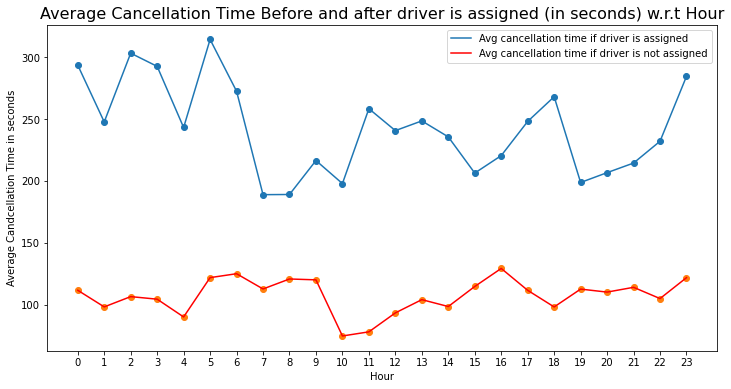

In [30]:
plt.figure(figsize=(12,6))
l1=sns.lineplot(x = "hour", y = "avg_driver_assigned_cancellation",data=df_avg_cancellation_time_by_hour,label="Avg cancellation time if driver is assigned")
ax1=sns.lineplot(x = "hour", y = "avg_driver_not_assigned_cancellation",data=df_avg_cancellation_time_by_hour ,color='r',label = "Avg cancellation time if driver is not assigned")
l1.set_xticks(range(24))
plt.scatter(x = "hour", y = "avg_driver_assigned_cancellation", data=df_avg_cancellation_time_by_hour)
plt.scatter(x="hour",y="avg_driver_not_assigned_cancellation",data=df_avg_cancellation_time_by_hour)
plt.xlabel("Hour")
plt.ylabel("Average Candcellation Time in seconds")

plt.title("Average Cancellation Time Before and after driver is assigned (in seconds) w.r.t Hour", fontdict=TITLE_SIZE)
plt.show()

From the line chart we can understand that 

<li>People tend to wait <b>126 % more</b> when the driver is assigned as compared to not assigned.
<li>The average waiting time before cancellation for customers if driver is  assigned is  <b>4 minutes 2 seconds. </b>
<li>The average waiting time before cancellation for customers if driver is not assigned is <b>1 minutes 47 seconds. </b></li>




### Question 4 

Plot the distribution of average ETA by hours. How can this plot be explained?

In [31]:
query_avg_eta_driver = """   

 SELECT 
  EXTRACT(hour from order_datetime) as hour 
  ,ROUND(AVG(m_order_eta),2) as avg_eta 
  
FROM `failed-orders-insights.failed_orders.data_orders_table` 
where is_driver_assigned_key = 1
GROUP BY hour
order by 1 
LIMIT 30


"""

df_avg_eta_driver = execute_query(query_avg_eta_driver,ONE_GB)
df_avg_eta_driver.head(3)

median_eta = df_avg_eta_driver['avg_eta'].median()
median_eta

399.72

<i>Creating a line chart to show the average time of ETA by hour</i> 

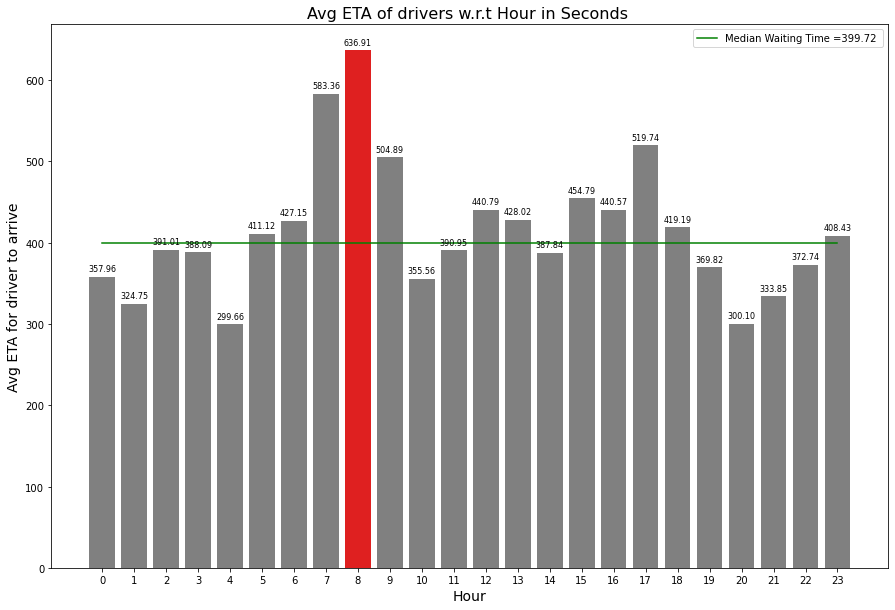

In [32]:
plt.figure(figsize=(15,10))
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
values_list = list(df_avg_eta_driver['avg_eta'])
columns_list= list(df_avg_eta_driver['hour'])

# plt.figure(figsize=FIGSIZE)
clrs = ['grey' if (x < max(values_list)) else 'red' for x in values_list ]
plots = sns.barplot(x=columns_list, y=values_list,palette=clrs)
ax1 = sns.lineplot(x = "hour", y = median_eta , data=df_avg_eta_driver,color='green',label = "Median Waiting Time =399.72 ")


# Iterrating over the bars one-by-one
for bar in plots.patches:

# Using Matplotlib's annotate function and
# passing the coordinates where the annotation shall be done
# x-coordinate: bar.get_x() + bar.get_width() / 2
# y-coordinate: bar.get_height()
# free space to be left to make graph pleasing: (0, 8)
# ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
    (bar.get_x() + bar.get_width() / 2,
     bar.get_height()), ha='center', va='center',
    size=8, xytext=(0, 8),
    textcoords='offset points')

# Setting the label for x-axis
plt.xlabel("Hour", size=LABEL_SIZE)

# Setting the label for y-axis
plt.ylabel("Avg ETA for driver to arrive", size=LABEL_SIZE)

fontsize= 16
# Setting the title for the graph
plt.title("Avg ETA of drivers w.r.t Hour in Seconds ", fontdict=TITLE_SIZE)

# Finally showing the plot
plt.show()


We can see from the line chart that
<li> The morning slot (7am-9am) has the <b>highest ETA = 9 minutes 35 seconds.</b>
<li> This highly correlates with the amount of cancellations that are happening throughtout the day.

### Estimating reduction in Cancellations.

In [27]:
# estimating the sucess rate if the "not assigned drivers" are getting assigned 
# and only 15% of them get converted to successful deliveries. 

query_count_driver_not_assigned="""   


-- Query to find number of not assigned people and total people 
SELECT 

  COUNT(CASE WHEN is_driver_assigned_key=0 then 1 else NULL end) as count_not_assigned_driver
  ,COUNT(1) as total_entries

FROM `failed-orders-insights.failed_orders.data_orders_table`

"""

df_count_driver_not_assigned=execute_query(query_count_driver_not_assigned,ONE_GB)
count_not_assigned=int(df_count_driver_not_assigned['count_not_assigned_driver'])
print("There are ",count_not_assigned," instances where driver was nopt assigned. If we even consider 15% of orders do get assigned and result it succesfull deliveries")

converted_drivers=0.15*count_not_assigned
print(converted_drivers," = converted riders")
failed_reduction = (int(df_count_driver_not_assigned['total_entries']) - converted_drivers)/converted_drivers
failed_reduction = int(failed_reduction)
print("The Failed order would have a decrease of around ",failed_reduction," %")

There are  7902  instances where driver was nopt assigned. If we even consider 15% of orders do get assigned and result it succesfull deliveries
1185.3  = converted riders
The Failed order would have a decrease of around  8  %


In [28]:
# CALCULATING that if  10% of ETA is reduced to average or made less than average
#  then estimating the reduction in cancellation rate

query_eta_above_avg_count = """   

with eta_above_avg_count as (
 SELECT 
 ROUND(AVG(m_order_eta),2) as avg_eta  
 ,COUNT(1) as total_entries
FROM `failed-orders-insights.failed_orders.data_orders_table` 
where is_driver_assigned_key = 1 

)
select 
total_entries
,COUNT(case when m_order_eta >  avg_eta then 1 else null end ) as  count_above_average_eta

 from eta_above_avg_count,`failed-orders-insights.failed_orders.data_orders_table`
 group by total_entries

 """


df_eta_above_avg_count = execute_query(query_eta_above_avg_count,ONE_GB)
eta_above_avg_count = int(df_eta_above_avg_count['count_above_average_eta'])
TEST = int(df_eta_above_avg_count['total_entries'])
total_entries_eta = TEST
print("Out of ",eta_above_avg_count," above average ETA rides EVEN if 10 percent rides lower their eta to average or less than average value and get converted to successful rides then ")
# calculating 10 percent of reduced average eta rides.
converted_if_eta_made_less_to_avg=0.10*eta_above_avg_count

print("PCT change is",(eta_above_avg_count-converted_if_eta_made_less_to_avg)/converted_if_eta_made_less_to_avg,"%")

Out of  1205  above average ETA rides EVEN if 10 percent rides lower their eta to average or less than average value and get converted to successful rides then 
PCT change is 9.0 %


### Factors for Failure of Rides

<p>
<li>On Comparing the results, we can find that <b>Driver not being assigned</b> to a customer is the most frequent reason for cancellation of  orders. It constituents for <b>74% </b> for the cancellation reason. 

<li>When taking the median cancellation count i.e 298 as the threshold value, we find that 50% hours in a day crossed these thresholds. These are :<li>Midnight --> 12am - 2am 
<li>Morning --> 7am -9am 
<li>Evening --> 5pm - 7pm 
<li>Night    --> 8pm-10pm
<br><br>

<li> The morning time period, which is from <b>7am to 9am</b>, has a high demand for rides. The greatest number of cancellations and longest wait times occur at 8 a.m. The reason for this peak hour may be due to regular office hours, when people tend to leave for the day.

<li>High waiting times can contribute to more cancellations. An average of 8 to 10 minutes pass while waiting in the morning slot.

<li>There is a <b>minimum of 25% difference </b> between cancellation by customer and cancellation by driver during peak hours, which needs to be addressed.

<li>The morning slot (7am-9am) has the <b>highest ETA = 9 minutes 35 seconds.





</p>

### Strategies to Reduce Cancellation Rate


1. More drivers should be hired so that customers won't experience the problem of a driver not being assigned. If we even consider 15% of the 7902 cancellations due to unassigned drivers result in successful deliveries, the failed orders would <b>have a reduction of 8%.</b>
<hr>

2. Identifying a method by which we can lower the drivers' ETA. If even 10% of orders with high ETAs are reduced to orders with ETAs below average, we can <b>anticipate a 9% decrease in failed orders.</b> 
<hr>


3. The average waiting time before cancellation for customers if driver is  assigned is  <b>4 minutes 2 seconds. </b>
The average waiting time before cancellation for customers if driver is not assigned is <b>1 minutes 47 seconds. </b>.<br><br>When the current ride is almost over, we can extend the period before the driver can accept the following one. As people <b>tend to wait 126% longer</b> for their ride when the driver is assigned as opposed to not assigned, we can significantly lower our cancellation rate.
